# Star galaxy separation 

Here I seperate images of stars and galaxies from each other. This is my first attempt on image data. I choose this problem because it is relatively simple, at least with sufficient signal to noise star. Galaxies should be relatively easy to separate because stars are a homogenous class and while galaxies are less simple, they should be usually larger than stars. 

This notebook is the last of several and applies many steps learned before. 
First I load the needed libraries. 

In [6]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss, ConfusionMatrixDisplay
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
#own functions
from functions_ml import *
from functions_wcs import *
#for accesing saved models  
#import pickle
#supresses warnings, which dont matter
#import warnings
#warnings.filterwarnings('ignore')

## Data introduction

Now I am loading the table and associated images on the classification and other properties of the objects to be classified. 

This is done in get_small_objects.py  Afer exploration of other options in the other notebooks I use several criteria to ensure clean samples of stars and galaxies. I ignore QSO (quasi stellar objects) because while they usually very similar to stars it is not 100% the case. In addition I combine spectral class (star versus galaxy) classfications with shape based criteria. For the latter I require that the shape is star like in the images in all three filters with highest signal to noise ration. These are images in g, r and i. 
I choose as size of the cutout image a box radius of 11. That is relatively small because stars should be clear with a small window size and a larger one would be only a waste. It is not clear that this is the optimal size. 

These images are now loaded and the classes statistic is shown. 

In [7]:
#now loading more files 
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_small_im.npy') ]
list_images.sort()
print(list_images)
#ggeti9ng the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_small_table.csv')]
list_tables.sort()
#7 misisng bit not a proiblem
print(list_tables)
#df2=pd.read_csv('stripe82_1_small_table.csv')
#cut_outs2=np.load('stripe82_1_small_im.npy')
#print(df2['class'].value_counts())
#combine a subset
n_sets=4
cut_outs2=comb_nump_4d(list_images[0:n_sets])
print(cut_outs2.shape)
list_df=[]
for i in range(n_sets):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}")   
df2=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df2.shape}")
print(f"shape of image file is {cut_outs2.shape}")

['stripe82_01_small_im.npy', 'stripe82_02_small_im.npy', 'stripe82_03_small_im.npy', 'stripe82_04_small_im.npy', 'stripe82_05_small_im.npy', 'stripe82_06_small_im.npy', 'stripe82_08_small_im.npy', 'stripe82_09_small_im.npy', 'stripe82_10_small_im.npy', 'stripe82_11_small_im.npy', 'stripe82_12_small_im.npy', 'stripe82_13_small_im.npy', 'stripe82_14_small_im.npy', 'stripe82_15_small_im.npy', 'stripe82_16_small_im.npy', 'stripe82_17_small_im.npy', 'stripe82_18_small_im.npy', 'stripe82_19_small_im.npy', 'stripe82_20_small_im.npy', 'stripe82_21_small_im.npy', 'stripe82_22_small_im.npy', 'stripe82_23_small_im.npy', 'stripe82_24_small_im.npy', 'stripe82_25_small_im.npy', 'stripe82_26_small_im.npy', 'stripe82_27_small_im.npy', 'stripe82_28_small_im.npy', 'stripe82_29_small_im.npy', 'stripe82_30_small_im.npy', 'stripe82_31_small_im.npy', 'stripe82_32_small_im.npy', 'stripe82_33_small_im.npy', 'stripe82_34_small_im.npy', 'stripe82_35_small_im.npy', 'stripe82_36_small_im.npy', 'stripe82_37_small_

There are about twice as much galaxies as star. This imbalance is probably small enough that it can be ignored.

Now I display two galaxies. 

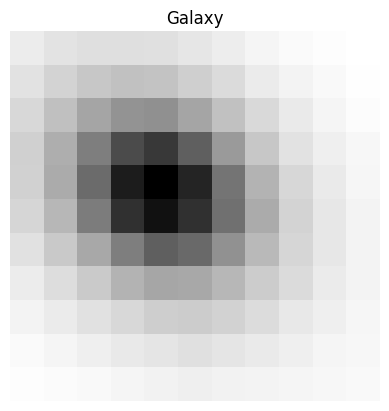

In [8]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,0].T,cmap=cm.gray, interpolation='nearest')

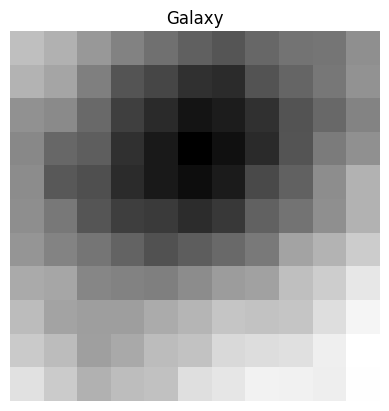

In [9]:
fg=df2['class'][df2['class']=='GALAXY']
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,fg.index[1]].T,cmap=cm.gray, interpolation='nearest')

It is visible that there is variation in galaxy shape. Now two stars. 

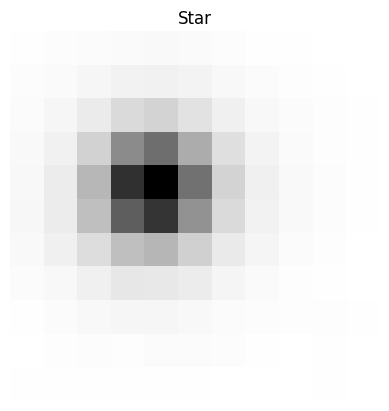

In [10]:
#finding star for display
fs=df2['class'][df2['class']=='STAR']
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

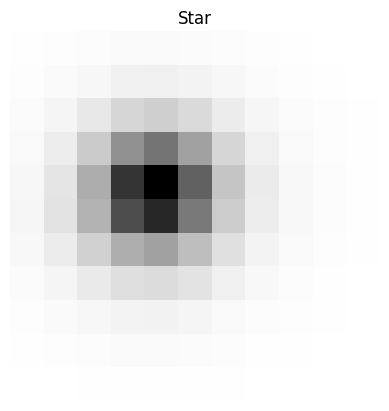

In [11]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[1]].T,cmap=cm.gray, interpolation='nearest')

In contrast, different stars look very similar when scaled to their maxima. As it should be the galaxies are less concentrated than the stars. 

Because of the relevant noise in astronomical images I do not rescale the cut-out images, since rescaling can cause that noise level is very different between different images, while it should be rather similar in this data set.   

## Fit preparation

I use four different algorithms here. Two which do not use neural network, that are logisted regression and the tree based algorithm xgboost. In addition I use two neural networks: Firstly a fully connected multilayer network with several layers as perceptron. Secondly, a network which uses among others twodimensional convolutional layers, this network should be optimized for images. 

I now start with the setup tasks for the algorithm. Many are needed for the use of pytorch.
First I add the cpu. 

In [12]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


Next I add the image columns to the data frame as flattened columns. That is needed because all algorithms besides convolutional cannot work on images as input.  

In [13]:
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1
print(df2.columns)   

Index(['Unnamed: 0',      'index',      'objid',         'ra',        'dec',
         'psfMag_u',   'psfMag_g',   'psfMag_r',   'psfMag_i',   'psfMag_z',
       ...
                111,          112,          113,          114,          115,
                116,          117,          118,          119,          120],
      dtype='object', length=292)


/tmp/ipykernel_25578/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_25578/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_25578/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

Next I split into test and train. 

In [15]:
#image_* are the feature for convoltional
# for other feature* are used 
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.50, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(9968, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [16]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create the data sets as needed for both neural network types. 

In [17]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())


Now I define the parameters needed for a first exploratory fit. 

In [18]:
NUM_FEATURES=121
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the the perceptron model plus the final parameters. 

In [19]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)

BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


This network has 3 layers before the output layer. 

## First fits

Now I run the fit. 

In [20]:
#data collected here
loss_stats_per = {
    'train': [], 'test': []
}
EPOCHS=60
LEARNING_RATE=0.001
torch_fit(model,train_loader,test_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_per)

Begin training.


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43140 | Test Loss: 0.29475
Epoch 002: | Train Loss: 0.29158 | Test Loss: 0.27448
Epoch 003: | Train Loss: 0.18337 | Test Loss: 0.10173
Epoch 004: | Train Loss: 0.11621 | Test Loss: 0.10349
Epoch 005: | Train Loss: 0.07905 | Test Loss: 0.16736
Epoch 006: | Train Loss: 0.06150 | Test Loss: 0.09348
Epoch 007: | Train Loss: 0.04787 | Test Loss: 0.05510
Epoch 008: | Train Loss: 0.03723 | Test Loss: 0.05656
Epoch 009: | Train Loss: 0.04965 | Test Loss: 0.05440
Epoch 010: | Train Loss: 0.01705 | Test Loss: 0.05513
Epoch 011: | Train Loss: 0.02727 | Test Loss: 0.06092
Epoch 012: | Train Loss: 0.01554 | Test Loss: 0.06879
Epoch 013: | Train Loss: 0.02440 | Test Loss: 0.05484
Epoch 014: | Train Loss: 0.04339 | Test Loss: 0.03671
Epoch 015: | Train Loss: 0.01801 | Test Loss: 0.03974
Epoch 016: | Train Loss: 0.02411 | Test Loss: 0.05514
Epoch 017: | Train Loss: 0.01441 | Test Loss: 0.05354
Epoch 018: | Train Loss: 0.01304 | Test Loss: 0.05559
Epoch 019: | Train Loss: 0.0

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

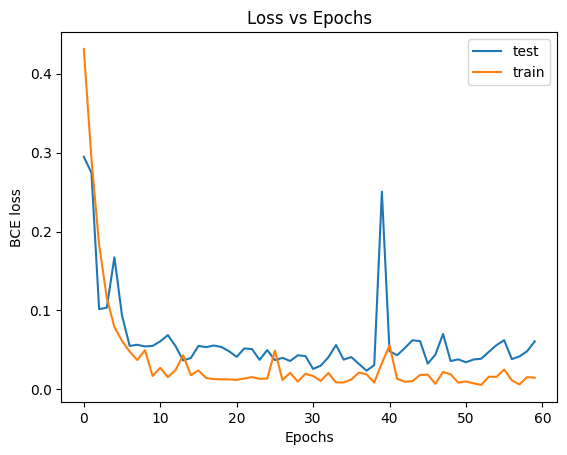

In [21]:

plt.plot(loss_stats_per['test'],label='test')
plt.plot(loss_stats_per['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

The loss clearly improves overall for test and train with some variation showing that it is not robust. The number of iteration here is likely not enough as expected in a first exploration. Since the loss is smaller in test there is likely overfitting. 

Now to the convolutional algorithm. The data needs to be loaded separately because now the images are used. 

In [22]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

I now load the convolutional neural network. 

In [23]:
keep_prob=1
model2 =CNNBinary3(keep_prob)
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


This network two structures consisting of convolutional layers and pooling which consider the image structures, then one multiconnected and finally a later to get the single probablity as output. 

Now define the dictionary for data collection and then fit the data. 

In [24]:
loss_stats_conv = {
    'train': [], 'test': []
}
EPOCHS=60
BATCH_SIZE=32
LEARNING_RATE=0.001
torch_fit(model2,train_im_loader,test_im_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_conv)

Begin training.


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.39436 | Test Loss: 0.32291
Epoch 002: | Train Loss: 0.26843 | Test Loss: 0.09436
Epoch 003: | Train Loss: 0.16455 | Test Loss: 0.08371
Epoch 004: | Train Loss: 0.11171 | Test Loss: 0.06640
Epoch 005: | Train Loss: 0.14340 | Test Loss: 0.07837
Epoch 006: | Train Loss: 0.05479 | Test Loss: 0.07716
Epoch 007: | Train Loss: 0.04358 | Test Loss: 0.04333
Epoch 008: | Train Loss: 0.16989 | Test Loss: 0.05620
Epoch 009: | Train Loss: 0.06275 | Test Loss: 0.07142
Epoch 010: | Train Loss: 0.02707 | Test Loss: 0.05454
Epoch 011: | Train Loss: 0.03128 | Test Loss: 0.03789
Epoch 012: | Train Loss: 0.02331 | Test Loss: 0.03316
Epoch 013: | Train Loss: 0.02372 | Test Loss: 0.05643
Epoch 014: | Train Loss: 0.02475 | Test Loss: 0.02656
Epoch 015: | Train Loss: 0.02122 | Test Loss: 0.02544
Epoch 016: | Train Loss: 0.02088 | Test Loss: 0.02715
Epoch 017: | Train Loss: 0.03543 | Test Loss: 0.02543
Epoch 018: | Train Loss: 0.02294 | Test Loss: 0.02443
Epoch 019: | Train Loss: 0.0

Below I plot both neural network results. 

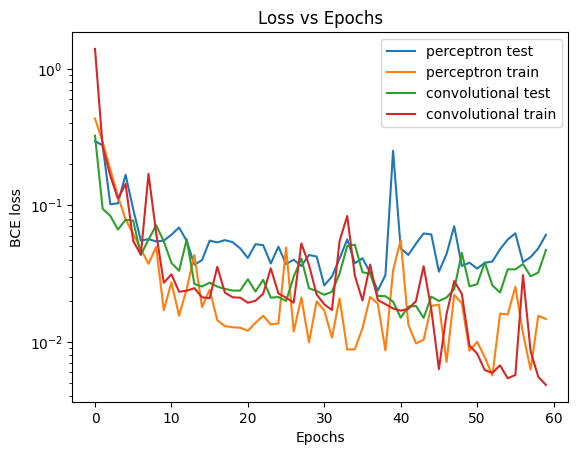

In [25]:
plt.plot(loss_stats_per['test'],label='perceptron test')
plt.plot(loss_stats_per['train'],label='perceptron train')
plt.plot(loss_stats_conv['test'],label='convolutional test')
plt.plot(loss_stats_conv['train'],label='convolutional train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.yscale("log")
#plt.ylim(0,2)


Convolutional looks better, but there is overfitting, the final loss is not the best. 

Now I do some other algorithms with standard settings. First xgboost. 

In [26]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now logistic regression. 

In [31]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=6000,penalty='none').fit(feature_train,target_train)

Now I predict results and get confusing matrixes. 

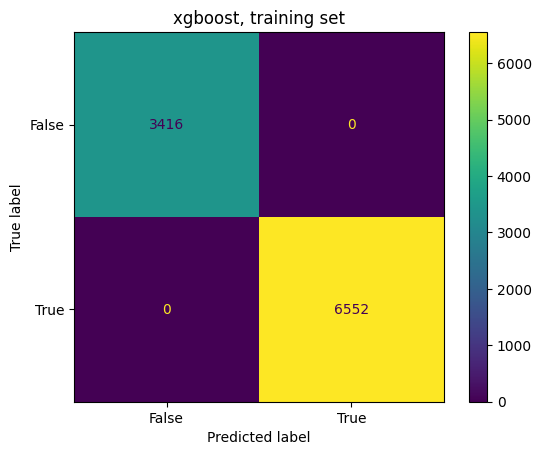

In [28]:
x_pred_train=xc1.predict(feature_train)
x_pred_test=xc1.predict(feature_test)
x_pred_prob_train=xc1.predict_proba(feature_train)
x_pred_prob_test=xc1.predict_proba(feature_test)
x_conf_train = confusion_matrix(target_train, np.round(x_pred_train), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_train,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

In the training set the classfication is perfect, indicating likely overfitting.


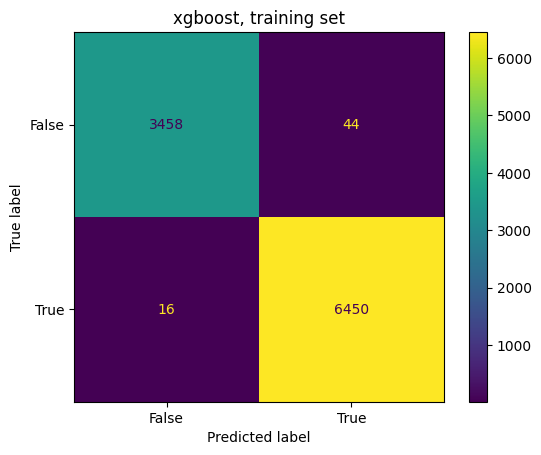

In [29]:
x_conf_test = confusion_matrix(target_test, np.round(x_pred_test), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_test,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

Here 44/16 are missiclasfied confirming that there is over fitting.

Now logistic regression. 

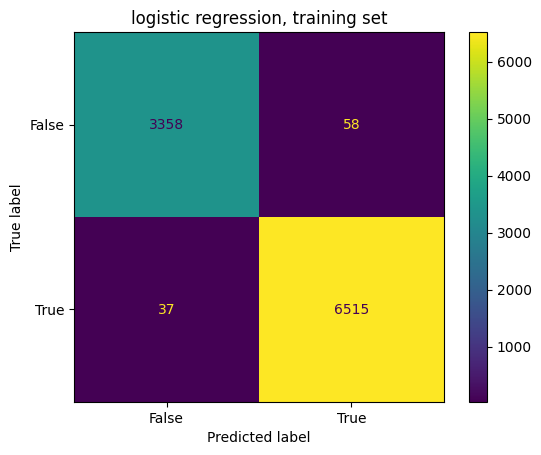

In [32]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, training set")
plt.show()

For using 4 sets not anymore perfect classification here.  

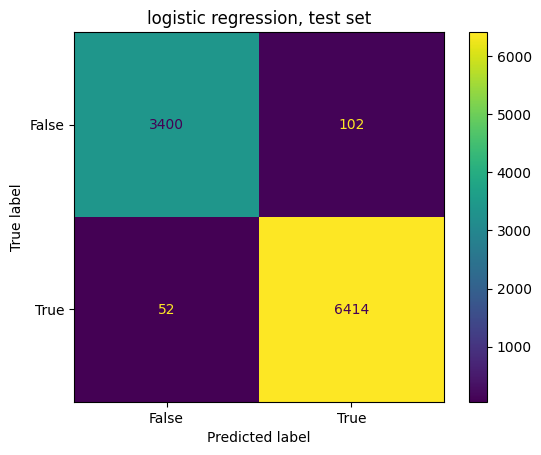

In [33]:
l_conf_test = confusion_matrix(target_test, np.round(l_test_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, test set")
plt.show()

Now also clearly mpre missclassified in test than for xgboost. 

Now prediction for neural network. 

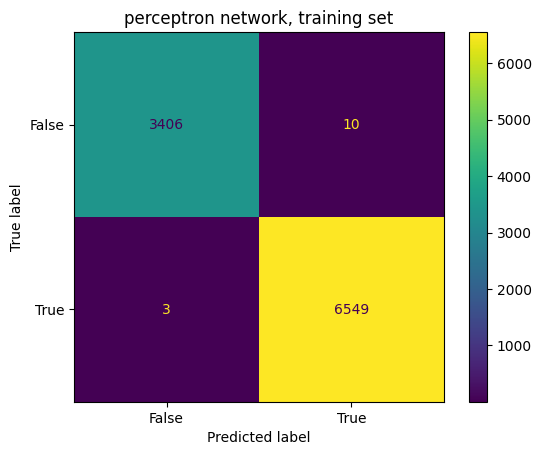

In [34]:
p_pred_test=pred_torch(model,test_loader)
p_pred_train=pred_torch(model,train_loader_pred)
p_conf_train = confusion_matrix(target_train, np.round(p_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, training set")
plt.show()

Here the classification is not perfect in training. Possible the fit is not yet converged. Howver, it is still small compared to the total numbers.

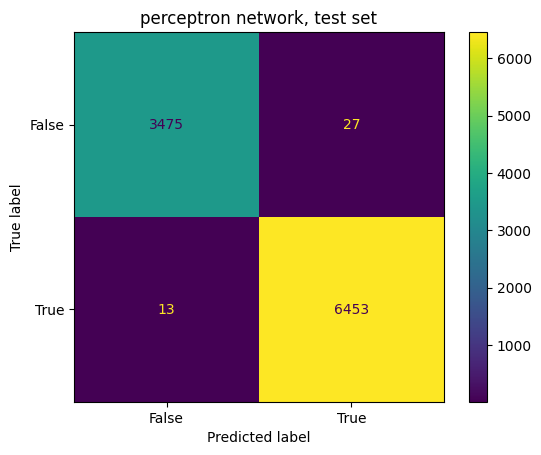

In [35]:
p_conf_test = confusion_matrix(target_test, np.round(p_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, test set")
plt.show()

In test it is better than xgboost not my a big a big factor but clearly.

Now convolutional network. 

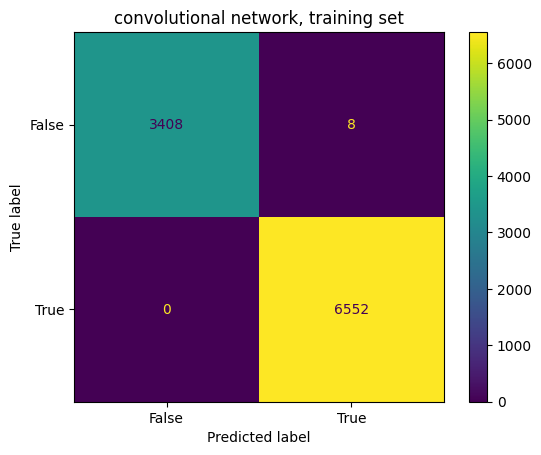

In [36]:
c_pred_test=pred_torch(model2,test_im_loader)
c_pred_train=pred_torch(model2,train_im_loader_pred)
c_conf_train = confusion_matrix(target_train, np.round(c_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, training set")
plt.show()

This is nearly perfect in train, which is likely overfitting. Again checking with test. 

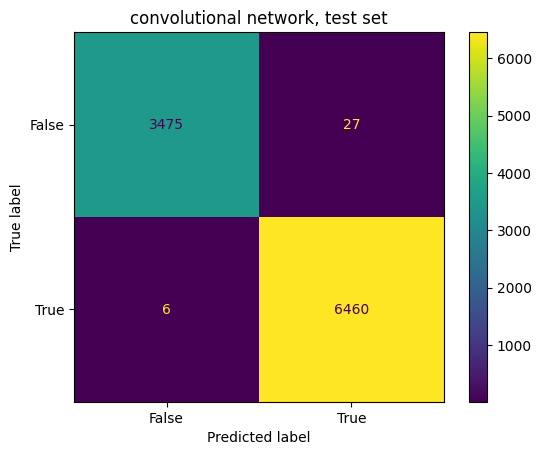

In [37]:
c_conf_test = confusion_matrix(target_test, np.round(c_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, test set")
plt.show()

This is slightly better than the perecptron, thus it is the best method, but the differences are small for the data size. 

Now I am calculating f1-scores for all. 

In [38]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")

F1-scores
Logistic train 0.99276
Logistic test 0.98814
xgboost train 1.0
xgboost test 0.99537
perceptron train 0.99901
perceptron test 0.99691
conv2d train 0.99939
conv2d test 0.99745


All rather good, the differences are small. In test convolutional network is best, then xgboost, then preceptron, then logistic regression.
Always test is worse than train, such there is overfitting. 

As strategy against it I use l2 regularization because that is possible for all algorithms. 

I  now run  convolutional network for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [46]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
#here a small regulrization is done for speed
n_it=30
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,n_it,64,0.001,regs)
np.savetxt("conv2d_reg1_"+str(n_it)+"_4sets.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_reg1_30_4sets.txt")

running reg of 0.0001
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.69272 | Test Loss: 0.14275
Epoch 002: | Train Loss: 0.25826 | Test Loss: 0.25798
Epoch 003: | Train Loss: 0.31616 | Test Loss: 0.16737
Epoch 004: | Train Loss: 0.11904 | Test Loss: 0.06255
Epoch 005: | Train Loss: 0.03845 | Test Loss: 0.08710
Epoch 006: | Train Loss: 0.03839 | Test Loss: 0.03414
Epoch 007: | Train Loss: 0.10450 | Test Loss: 0.07684
Epoch 008: | Train Loss: 0.04753 | Test Loss: 0.06780
Epoch 009: | Train Loss: 0.03657 | Test Loss: 0.06344
Epoch 010: | Train Loss: 0.07326 | Test Loss: 0.07459
Epoch 011: | Train Loss: 0.02614 | Test Loss: 0.07784
Epoch 012: | Train Loss: 0.01591 | Test Loss: 0.04741
Epoch 013: | Train Loss: 0.02599 | Test Loss: 0.02390
Epoch 014: | Train Loss: 0.05437 | Test Loss: 0.03530
Epoch 015: | Train Loss: 0.01563 | Test Loss: 0.02426
Epoch 016: | Train Loss: 0.02479 | Test Loss: 0.02283
Epoch 017: | Train Loss: 0.01323 | Test Loss: 0.03290
Epoch 018: | Train Loss: 0.01209 | Test Loss: 0.03095
Epoch 019: | Train Loss: 0.0

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 21.07587 | Test Loss: 0.29252
Epoch 002: | Train Loss: 0.12886 | Test Loss: 0.04345
Epoch 003: | Train Loss: 0.06750 | Test Loss: 0.04639
Epoch 004: | Train Loss: 0.05736 | Test Loss: 0.04385
Epoch 005: | Train Loss: 0.06775 | Test Loss: 0.03463
Epoch 006: | Train Loss: 0.05554 | Test Loss: 0.02765
Epoch 007: | Train Loss: 0.02231 | Test Loss: 0.02291
Epoch 008: | Train Loss: 0.03681 | Test Loss: 0.04199
Epoch 009: | Train Loss: 0.03889 | Test Loss: 0.02090
Epoch 010: | Train Loss: 0.01997 | Test Loss: 0.02107
Epoch 011: | Train Loss: 0.04534 | Test Loss: 0.02469
Epoch 012: | Train Loss: 0.02281 | Test Loss: 0.01808
Epoch 013: | Train Loss: 0.01758 | Test Loss: 0.01655
Epoch 014: | Train Loss: 0.01636 | Test Loss: 0.01617
Epoch 015: | Train Loss: 0.02247 | Test Loss: 0.03004
Epoch 016: | Train Loss: 0.02822 | Test Loss: 0.01759
Epoch 017: | Train Loss: 0.02493 | Test Loss: 0.01649
Epoch 018: | Train Loss: 0.02355 | Test Loss: 0.02144
Epoch 019: | Train Loss: 0.

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.70094 | Test Loss: 0.11649
Epoch 002: | Train Loss: 0.31957 | Test Loss: 0.09985
Epoch 003: | Train Loss: 0.12501 | Test Loss: 0.09291
Epoch 004: | Train Loss: 0.05980 | Test Loss: 0.12589
Epoch 005: | Train Loss: 0.03145 | Test Loss: 0.07654
Epoch 006: | Train Loss: 0.04226 | Test Loss: 0.03993
Epoch 007: | Train Loss: 0.05635 | Test Loss: 0.04551
Epoch 008: | Train Loss: 0.03400 | Test Loss: 0.02805
Epoch 009: | Train Loss: 0.02651 | Test Loss: 0.02838
Epoch 010: | Train Loss: 0.07386 | Test Loss: 0.04537
Epoch 011: | Train Loss: 0.04984 | Test Loss: 0.02552
Epoch 012: | Train Loss: 0.02710 | Test Loss: 0.03761
Epoch 013: | Train Loss: 0.03299 | Test Loss: 0.05183
Epoch 014: | Train Loss: 0.02539 | Test Loss: 0.02494
Epoch 015: | Train Loss: 0.02732 | Test Loss: 0.03317
Epoch 016: | Train Loss: 0.03090 | Test Loss: 0.02420
Epoch 017: | Train Loss: 0.02836 | Test Loss: 0.02859
Epoch 018: | Train Loss: 0.02305 | Test Loss: 0.03004
Epoch 019: | Train Loss: 0.0

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.57269 | Test Loss: 0.16302
Epoch 002: | Train Loss: 0.16376 | Test Loss: 0.12349
Epoch 003: | Train Loss: 0.13806 | Test Loss: 0.14086
Epoch 004: | Train Loss: 0.13270 | Test Loss: 0.12890
Epoch 005: | Train Loss: 0.12327 | Test Loss: 0.10000
Epoch 006: | Train Loss: 0.05947 | Test Loss: 0.06074
Epoch 007: | Train Loss: 0.03063 | Test Loss: 0.04958
Epoch 008: | Train Loss: 0.03664 | Test Loss: 0.06552
Epoch 009: | Train Loss: 0.02704 | Test Loss: 0.06697
Epoch 010: | Train Loss: 0.02577 | Test Loss: 0.09257
Epoch 011: | Train Loss: 0.05249 | Test Loss: 0.07975
Epoch 012: | Train Loss: 0.12948 | Test Loss: 0.05009
Epoch 013: | Train Loss: 0.05416 | Test Loss: 0.03561
Epoch 014: | Train Loss: 0.02703 | Test Loss: 0.03943
Epoch 015: | Train Loss: 0.02553 | Test Loss: 0.03601
Epoch 016: | Train Loss: 0.05735 | Test Loss: 0.02175
Epoch 017: | Train Loss: 0.01680 | Test Loss: 0.02882
Epoch 018: | Train Loss: 0.01550 | Test Loss: 0.02797
Epoch 019: | Train Loss: 0.0

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 34.12158 | Test Loss: 35.12401
Epoch 002: | Train Loss: 34.26603 | Test Loss: 35.12382
Epoch 003: | Train Loss: 34.26579 | Test Loss: 35.08127
Epoch 004: | Train Loss: 34.11247 | Test Loss: 35.13250
Epoch 005: | Train Loss: 34.27484 | Test Loss: 35.13250
Epoch 006: | Train Loss: 34.32492 | Test Loss: 35.13251
Epoch 007: | Train Loss: 34.26482 | Test Loss: 35.13251
Epoch 008: | Train Loss: 34.29487 | Test Loss: 35.13251
Epoch 009: | Train Loss: 34.23621 | Test Loss: 35.12402
Epoch 010: | Train Loss: 34.26592 | Test Loss: 35.10682
Epoch 011: | Train Loss: 34.23694 | Test Loss: 35.05255
Epoch 012: | Train Loss: 6.35150 | Test Loss: 0.08899
Epoch 013: | Train Loss: 0.05987 | Test Loss: 0.08608
Epoch 014: | Train Loss: 0.06229 | Test Loss: 0.10100
Epoch 015: | Train Loss: 0.08955 | Test Loss: 0.10121
Epoch 016: | Train Loss: 0.04162 | Test Loss: 0.07953
Epoch 017: | Train Loss: 0.06378 | Test Loss: 0.05018
Epoch 018: | Train Loss: 0.04700 | Test Loss: 0.04124
Epoch 

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 34.13315 | Test Loss: 35.13252
Epoch 002: | Train Loss: 34.25577 | Test Loss: 35.08100
Epoch 003: | Train Loss: 26.44273 | Test Loss: 0.17771
Epoch 004: | Train Loss: 0.31730 | Test Loss: 0.10933
Epoch 005: | Train Loss: 0.12671 | Test Loss: 0.07043
Epoch 006: | Train Loss: 0.09619 | Test Loss: 0.07574
Epoch 007: | Train Loss: 0.09626 | Test Loss: 0.08440
Epoch 008: | Train Loss: 0.09875 | Test Loss: 0.09109
Epoch 009: | Train Loss: 0.09915 | Test Loss: 0.06091
Epoch 010: | Train Loss: 0.15126 | Test Loss: 0.06351
Epoch 011: | Train Loss: 0.09042 | Test Loss: 0.07542
Epoch 012: | Train Loss: 0.11980 | Test Loss: 0.11365
Epoch 013: | Train Loss: 0.07939 | Test Loss: 0.05084
Epoch 014: | Train Loss: 0.07040 | Test Loss: 0.08172
Epoch 015: | Train Loss: 0.04278 | Test Loss: 0.05778
Epoch 016: | Train Loss: 0.11808 | Test Loss: 0.05922
Epoch 017: | Train Loss: 0.06663 | Test Loss: 0.41635
Epoch 018: | Train Loss: 0.07465 | Test Loss: 0.04121
Epoch 019: | Train Loss

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 4.88854 | Test Loss: 0.61674
Epoch 002: | Train Loss: 0.21045 | Test Loss: 0.12554
Epoch 003: | Train Loss: 0.15794 | Test Loss: 0.12444
Epoch 004: | Train Loss: 0.18550 | Test Loss: 0.12795
Epoch 005: | Train Loss: 0.13427 | Test Loss: 0.11718
Epoch 006: | Train Loss: 0.11567 | Test Loss: 0.11785
Epoch 007: | Train Loss: 0.11471 | Test Loss: 0.13092
Epoch 008: | Train Loss: 0.14483 | Test Loss: 0.11550
Epoch 009: | Train Loss: 0.18917 | Test Loss: 0.10570
Epoch 010: | Train Loss: 0.11947 | Test Loss: 0.57942
Epoch 011: | Train Loss: 0.10745 | Test Loss: 0.11927
Epoch 012: | Train Loss: 0.09252 | Test Loss: 0.13127
Epoch 013: | Train Loss: 0.13149 | Test Loss: 0.12712
Epoch 014: | Train Loss: 0.10272 | Test Loss: 0.11683
Epoch 015: | Train Loss: 0.11273 | Test Loss: 0.15347
Epoch 016: | Train Loss: 0.12253 | Test Loss: 0.14068
Epoch 017: | Train Loss: 0.12961 | Test Loss: 0.09700
Epoch 018: | Train Loss: 0.09246 | Test Loss: 0.14156
Epoch 019: | Train Loss: 0.1

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.52318 | Test Loss: 0.18425
Epoch 002: | Train Loss: 0.76026 | Test Loss: 0.14093
Epoch 003: | Train Loss: 0.22769 | Test Loss: 0.14657
Epoch 004: | Train Loss: 0.11596 | Test Loss: 0.09541
Epoch 005: | Train Loss: 0.19660 | Test Loss: 0.18492
Epoch 006: | Train Loss: 0.15061 | Test Loss: 0.18664
Epoch 007: | Train Loss: 0.17148 | Test Loss: 0.29849
Epoch 008: | Train Loss: 0.17490 | Test Loss: 0.44575
Epoch 009: | Train Loss: 0.14786 | Test Loss: 0.21135
Epoch 010: | Train Loss: 0.17362 | Test Loss: 0.18849
Epoch 011: | Train Loss: 0.13401 | Test Loss: 0.17485
Epoch 012: | Train Loss: 0.17210 | Test Loss: 0.16822
Epoch 013: | Train Loss: 0.18741 | Test Loss: 0.18166
Epoch 014: | Train Loss: 0.18659 | Test Loss: 0.14727
Epoch 015: | Train Loss: 0.15208 | Test Loss: 0.17485
Epoch 016: | Train Loss: 0.19277 | Test Loss: 0.18333
Epoch 017: | Train Loss: 0.18021 | Test Loss: 0.18891
Epoch 018: | Train Loss: 0.18606 | Test Loss: 0.22540
Epoch 019: | Train Loss: 0.1

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.32545 | Test Loss: 0.19203
Epoch 002: | Train Loss: 0.21604 | Test Loss: 0.42262
Epoch 003: | Train Loss: 0.27115 | Test Loss: 0.24833
Epoch 004: | Train Loss: 0.29397 | Test Loss: 0.24764
Epoch 005: | Train Loss: 0.32145 | Test Loss: 0.28303
Epoch 006: | Train Loss: 0.32132 | Test Loss: 0.29379
Epoch 007: | Train Loss: 0.34113 | Test Loss: 0.31588
Epoch 008: | Train Loss: 0.33698 | Test Loss: 0.29732
Epoch 009: | Train Loss: 0.35940 | Test Loss: 0.31476
Epoch 010: | Train Loss: 0.34815 | Test Loss: 0.32398
Epoch 011: | Train Loss: 0.38283 | Test Loss: 0.33731
Epoch 012: | Train Loss: 0.35882 | Test Loss: 0.30898
Epoch 013: | Train Loss: 0.35006 | Test Loss: 0.33176
Epoch 014: | Train Loss: 0.37350 | Test Loss: 0.34373
Epoch 015: | Train Loss: 0.33689 | Test Loss: 0.35492
Epoch 016: | Train Loss: 0.33887 | Test Loss: 0.31810
Epoch 017: | Train Loss: 0.37206 | Test Loss: 0.31645
Epoch 018: | Train Loss: 0.37985 | Test Loss: 0.33976
Epoch 019: | Train Loss: 0.3

Now running also the multi layer perceptron with different regularizations.

In [ ]:
regs=[0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
n_it=30
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,n_it,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_"+str(n_it)+"_4sets.txt",per_stats)
per_stats=np.loadtxt("per_reg1_30_4sets.txt")

running reg of 1e-05
Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.44878 | Test Loss: 0.29935
Epoch 002: | Train Loss: 0.33152 | Test Loss: 0.31717
Epoch 003: | Train Loss: 0.27278 | Test Loss: 0.18997
Epoch 004: | Train Loss: 0.16239 | Test Loss: 0.11866
Epoch 005: | Train Loss: 0.11230 | Test Loss: 0.19270
Epoch 006: | Train Loss: 0.11528 | Test Loss: 0.08137
Epoch 007: | Train Loss: 0.07260 | Test Loss: 0.04942
Epoch 008: | Train Loss: 0.06353 | Test Loss: 0.06736
Epoch 009: | Train Loss: 0.05395 | Test Loss: 0.05179
Epoch 010: | Train Loss: 0.06426 | Test Loss: 0.05886
Epoch 011: | Train Loss: 0.06596 | Test Loss: 0.07705
Epoch 012: | Train Loss: 0.06103 | Test Loss: 0.18502
Epoch 013: | Train Loss: 0.06362 | Test Loss: 0.04559
Epoch 014: | Train Loss: 0.04055 | Test Loss: 0.15821
Epoch 015: | Train Loss: 0.03038 | Test Loss: 0.05634
Epoch 016: | Train Loss: 0.02695 | Test Loss: 0.05937
Epoch 017: | Train Loss: 0.02504 | Test Loss: 0.06328
Epoch 018: | Train Loss: 0.01860 | Test Loss: 0.09717
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.32551 | Test Loss: 0.40268
Epoch 002: | Train Loss: 0.25614 | Test Loss: 0.22496
Epoch 003: | Train Loss: 0.22391 | Test Loss: 0.15281
Epoch 004: | Train Loss: 0.19889 | Test Loss: 0.17021
Epoch 005: | Train Loss: 0.10990 | Test Loss: 0.07648
Epoch 006: | Train Loss: 0.09796 | Test Loss: 0.08337
Epoch 007: | Train Loss: 0.08249 | Test Loss: 0.13990
Epoch 008: | Train Loss: 0.08974 | Test Loss: 0.04430
Epoch 009: | Train Loss: 0.03338 | Test Loss: 0.05360
Epoch 010: | Train Loss: 0.03510 | Test Loss: 0.03563
Epoch 011: | Train Loss: 0.02778 | Test Loss: 0.03179
Epoch 012: | Train Loss: 0.03642 | Test Loss: 0.02517
Epoch 013: | Train Loss: 0.03299 | Test Loss: 0.04009
Epoch 014: | Train Loss: 0.02494 | Test Loss: 0.07126
Epoch 015: | Train Loss: 0.03255 | Test Loss: 0.03953
Epoch 016: | Train Loss: 0.02643 | Test Loss: 0.06334
Epoch 017: | Train Loss: 0.03372 | Test Loss: 0.06038
Epoch 018: | Train Loss: 0.02095 | Test Loss: 0.03770
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.27651 | Test Loss: 0.16137
Epoch 002: | Train Loss: 0.16678 | Test Loss: 0.16688
Epoch 003: | Train Loss: 0.16255 | Test Loss: 0.21717
Epoch 004: | Train Loss: 0.15702 | Test Loss: 0.21606
Epoch 005: | Train Loss: 0.13811 | Test Loss: 0.07356
Epoch 006: | Train Loss: 0.05999 | Test Loss: 0.08364
Epoch 007: | Train Loss: 0.07339 | Test Loss: 0.06768
Epoch 008: | Train Loss: 0.06126 | Test Loss: 0.07140
Epoch 009: | Train Loss: 0.09234 | Test Loss: 0.10182
Epoch 010: | Train Loss: 0.08105 | Test Loss: 0.12450
Epoch 011: | Train Loss: 0.02545 | Test Loss: 0.04478
Epoch 012: | Train Loss: 0.02337 | Test Loss: 0.04550
Epoch 013: | Train Loss: 0.02320 | Test Loss: 0.04207
Epoch 014: | Train Loss: 0.01721 | Test Loss: 0.13362
Epoch 015: | Train Loss: 0.01701 | Test Loss: 0.03957
Epoch 016: | Train Loss: 0.02834 | Test Loss: 0.06813
Epoch 017: | Train Loss: 0.01641 | Test Loss: 0.04769
Epoch 018: | Train Loss: 0.03610 | Test Loss: 0.05292
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.39964 | Test Loss: 0.19860
Epoch 002: | Train Loss: 0.15933 | Test Loss: 0.15612
Epoch 003: | Train Loss: 0.07835 | Test Loss: 0.13740
Epoch 004: | Train Loss: 0.06785 | Test Loss: 0.08623
Epoch 005: | Train Loss: 0.03196 | Test Loss: 0.05549
Epoch 006: | Train Loss: 0.02794 | Test Loss: 0.07972
Epoch 007: | Train Loss: 0.05166 | Test Loss: 0.05208
Epoch 008: | Train Loss: 0.03373 | Test Loss: 0.06637
Epoch 009: | Train Loss: 0.03190 | Test Loss: 0.11158
Epoch 010: | Train Loss: 0.02371 | Test Loss: 0.04580
Epoch 011: | Train Loss: 0.03047 | Test Loss: 0.07943
Epoch 012: | Train Loss: 0.02909 | Test Loss: 0.04660
Epoch 013: | Train Loss: 0.03164 | Test Loss: 0.06879
Epoch 014: | Train Loss: 0.04299 | Test Loss: 0.03390
Epoch 015: | Train Loss: 0.04706 | Test Loss: 0.07747
Epoch 016: | Train Loss: 0.02641 | Test Loss: 0.05135
Epoch 017: | Train Loss: 0.03164 | Test Loss: 0.03084
Epoch 018: | Train Loss: 0.02981 | Test Loss: 0.08115
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59426 | Test Loss: 0.32165
Epoch 002: | Train Loss: 0.37195 | Test Loss: 0.26857
Epoch 003: | Train Loss: 0.24511 | Test Loss: 0.24624
Epoch 004: | Train Loss: 0.23122 | Test Loss: 0.16448
Epoch 005: | Train Loss: 0.14457 | Test Loss: 0.12031
Epoch 006: | Train Loss: 0.10220 | Test Loss: 0.11772
Epoch 007: | Train Loss: 0.12773 | Test Loss: 0.25952
Epoch 008: | Train Loss: 0.07516 | Test Loss: 0.08685
Epoch 009: | Train Loss: 0.07162 | Test Loss: 0.08402
Epoch 010: | Train Loss: 0.05015 | Test Loss: 0.10470
Epoch 011: | Train Loss: 0.04828 | Test Loss: 0.09286
Epoch 012: | Train Loss: 0.06885 | Test Loss: 0.06132
Epoch 013: | Train Loss: 0.04422 | Test Loss: 0.04781
Epoch 014: | Train Loss: 0.02676 | Test Loss: 0.06652
Epoch 015: | Train Loss: 0.02792 | Test Loss: 0.04045
Epoch 016: | Train Loss: 0.02717 | Test Loss: 0.04814
Epoch 017: | Train Loss: 0.03376 | Test Loss: 0.05723
Epoch 018: | Train Loss: 0.03994 | Test Loss: 0.05436
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.34350 | Test Loss: 0.23813
Epoch 002: | Train Loss: 0.20266 | Test Loss: 0.18792
Epoch 003: | Train Loss: 0.11053 | Test Loss: 0.15819
Epoch 004: | Train Loss: 0.10319 | Test Loss: 0.13670
Epoch 005: | Train Loss: 0.17003 | Test Loss: 0.11575
Epoch 006: | Train Loss: 0.08101 | Test Loss: 0.07593
Epoch 007: | Train Loss: 0.07188 | Test Loss: 0.08457
Epoch 008: | Train Loss: 0.09434 | Test Loss: 0.08922
Epoch 009: | Train Loss: 0.06580 | Test Loss: 0.07490
Epoch 010: | Train Loss: 0.06805 | Test Loss: 0.11350
Epoch 011: | Train Loss: 0.04413 | Test Loss: 0.08763
Epoch 012: | Train Loss: 0.06353 | Test Loss: 0.06365
Epoch 013: | Train Loss: 0.09582 | Test Loss: 0.05227
Epoch 014: | Train Loss: 0.03446 | Test Loss: 0.07791
Epoch 015: | Train Loss: 0.03161 | Test Loss: 0.05993
Epoch 016: | Train Loss: 0.03034 | Test Loss: 0.09477
Epoch 017: | Train Loss: 0.02970 | Test Loss: 0.11771
Epoch 018: | Train Loss: 0.03974 | Test Loss: 0.06901
Epoch 019: | Train Loss: 0.1

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.51184 | Test Loss: 0.22928
Epoch 002: | Train Loss: 0.29895 | Test Loss: 0.29847
Epoch 003: | Train Loss: 0.24736 | Test Loss: 0.24656
Epoch 004: | Train Loss: 0.21350 | Test Loss: 0.14641
Epoch 005: | Train Loss: 0.20989 | Test Loss: 0.13722
Epoch 006: | Train Loss: 0.12973 | Test Loss: 0.09580
Epoch 007: | Train Loss: 0.11942 | Test Loss: 0.08031
Epoch 008: | Train Loss: 0.08872 | Test Loss: 0.10332
Epoch 009: | Train Loss: 0.07242 | Test Loss: 0.08897
Epoch 010: | Train Loss: 0.06996 | Test Loss: 0.05730
Epoch 011: | Train Loss: 0.07088 | Test Loss: 0.09105
Epoch 012: | Train Loss: 0.07310 | Test Loss: 0.10917
Epoch 013: | Train Loss: 0.04491 | Test Loss: 0.05940
Epoch 014: | Train Loss: 0.04773 | Test Loss: 0.10327
Epoch 015: | Train Loss: 0.04103 | Test Loss: 0.14429
Epoch 016: | Train Loss: 0.04404 | Test Loss: 0.15242
Epoch 017: | Train Loss: 0.06340 | Test Loss: 0.08114
Epoch 018: | Train Loss: 0.05085 | Test Loss: 0.13472
Epoch 019: | Train Loss: 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.36754 | Test Loss: 0.29792
Epoch 002: | Train Loss: 0.32102 | Test Loss: 0.34575
Epoch 003: | Train Loss: 0.25858 | Test Loss: 0.25813
Epoch 004: | Train Loss: 0.21710 | Test Loss: 0.25136
Epoch 005: | Train Loss: 0.19208 | Test Loss: 0.24553
Epoch 006: | Train Loss: 0.22108 | Test Loss: 0.26448
Epoch 007: | Train Loss: 0.15604 | Test Loss: 0.28453
Epoch 008: | Train Loss: 0.10551 | Test Loss: 0.20395
Epoch 009: | Train Loss: 0.10374 | Test Loss: 0.59208
Epoch 010: | Train Loss: 0.11731 | Test Loss: 0.08124
Epoch 011: | Train Loss: 0.14556 | Test Loss: 0.10861
Epoch 012: | Train Loss: 0.08427 | Test Loss: 0.13595
Epoch 013: | Train Loss: 0.11630 | Test Loss: 0.55866
Epoch 014: | Train Loss: 0.11806 | Test Loss: 0.20165
Epoch 015: | Train Loss: 0.12381 | Test Loss: 0.07833
Epoch 016: | Train Loss: 0.12027 | Test Loss: 0.29256
Epoch 017: | Train Loss: 0.10098 | Test Loss: 0.12591
Epoch 018: | Train Loss: 0.07811 | Test Loss: 0.14540
Epoch 019: | Train Loss: 0.0

Now also adding regularization to xgboost.

In [39]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
np.savetxt("xgboost_4sets_star_galaxies.txt",stats_xgb)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000


Now also adding logistic regression with l2 regularization. 

In [40]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
#adding max_its =x at the end 10000 is default but was still o.k. here 
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
np.savetxt("logistic_4sets_star_galaxies.txt",stats_log)

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100


Below I plot the F1 score for all. 

not regularized
Logistic train 0.99276
Logistic test 0.98814
xgboost train 1.0
xgboost test 0.99537
perceptron train 0.99901
perceptron test 0.99691
convolutional train 0.99939
convolutional test 0.99745
best regularized
xgboost train 1.0
xgboost test 0.99568
logistic train 0.99307
logistic test 0.98922
perceptron train 0.99688
perceptron test 0.99568
convolutional train 0.99878
convolutional test 0.99838


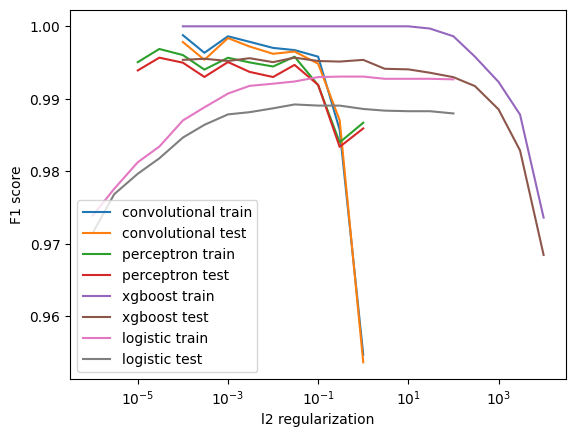

In [47]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='convolutional train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='convolutional test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"convolutional train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"convolutional test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"convolutional train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"convolutional test {np.round(np.max(conv2d_stats[2]),5)}")

Is improved now in test for all besides xgboost for its stays constant. Best is convolutional network, then perceptron, then on the same level logistic and xgboost. There are so few wrong, that it can be partlz chnace. Log loss depends less on stat statistic, thus I also look on this measure now. 

not regularized
Logistic train 0.02833
Logistic test 0.13177
xgboost train 0.00064
xgboost test 0.02459
perceptron train 0.00704
perceptron test 0.03457
convolutional train 0.0041
convolutional test 0.02653
best regularized
xgboost train 0.00044
xgboost test 0.02277
logistic train 0.02833
logistic test 0.10469
perceptron train 0.02016
perceptron test 0.03231
convolutional train 0.01873
convolutional test 0.02959


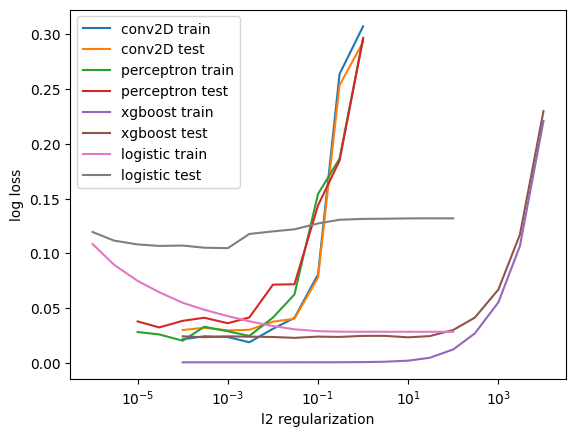

In [44]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,x_pred_prob_train),5)}")
print(f"xgboost test {np.round(log_loss(target_test,x_pred_prob_test),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(p_pred_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(p_pred_test)),5)}")
print(f"convolutional train {np.round(log_loss(target_train,(c_pred_train)),5)}")
print(f"convolutional test {np.round(log_loss(target_test,(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"convolutional train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"convolutional test {np.round(np.min(conv2d_stats[4]),5)}")

Similar but not identical. Best is convoltional network, then xgboost, then logistic then perceptron, all achioeve rather values.

## Final fits

As the next step I run the best of all four algorithm. I decide to use log loss as to find the best one. 


First I print the values.

In [84]:
best_reg_conv=conv2d_stats[0,int(np.argmin(conv2d_stats[4,0:]))]
print(f"best regularization of convolutional is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of convolutional is 0.0003
best regularization of perceptron is 0.03
best regularization of xgboost is 3.0
best regularization of logistic is 0.0003


In [85]:
xc2=XGBClassifier(max_depth=6,reg_lambda=3.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [86]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [80]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.03)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.38840 | Test Loss: 0.17213
Epoch 002: | Train Loss: 0.27422 | Test Loss: 0.27228
Epoch 003: | Train Loss: 0.29803 | Test Loss: 0.18071
Epoch 004: | Train Loss: 0.32367 | Test Loss: 0.25876
Epoch 005: | Train Loss: 0.29180 | Test Loss: 0.25983
Epoch 006: | Train Loss: 0.31184 | Test Loss: 0.25652
Epoch 007: | Train Loss: 0.28726 | Test Loss: 0.25025
Epoch 008: | Train Loss: 0.28421 | Test Loss: 0.26624
Epoch 009: | Train Loss: 0.32578 | Test Loss: 0.25650
Epoch 010: | Train Loss: 0.32512 | Test Loss: 0.25564
Epoch 011: | Train Loss: 0.31148 | Test Loss: 0.24919
Epoch 012: | Train Loss: 0.26411 | Test Loss: 0.19570
Epoch 013: | Train Loss: 0.30909 | Test Loss: 0.24582
Epoch 014: | Train Loss: 0.31838 | Test Loss: 0.25286
Epoch 015: | Train Loss: 0.30524 | Test Loss: 0.11984
Epoch 016: | Train Loss: 0.30872 | Test Loss: 0.12391
Epoch 017: | Train Loss: 0.28346 | Test Loss: 0.18588
Epoch 018: | Train Loss: 0.31051 | Test Loss: 0.12952
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.12220 | Test Loss: 0.16372
Epoch 154: | Train Loss: 0.04721 | Test Loss: 0.15947
Epoch 155: | Train Loss: 0.05000 | Test Loss: 0.16775
Epoch 156: | Train Loss: 0.06205 | Test Loss: 0.16350
Epoch 157: | Train Loss: 0.04415 | Test Loss: 0.23424
Epoch 158: | Train Loss: 0.05289 | Test Loss: 0.09459
Epoch 159: | Train Loss: 0.04726 | Test Loss: 0.09088
Epoch 160: | Train Loss: 0.04254 | Test Loss: 0.08995
Epoch 161: | Train Loss: 0.04203 | Test Loss: 0.09135
Epoch 162: | Train Loss: 0.05718 | Test Loss: 0.11296
Epoch 163: | Train Loss: 0.04577 | Test Loss: 0.09083
Epoch 164: | Train Loss: 0.04291 | Test Loss: 0.16418
Epoch 165: | Train Loss: 0.04238 | Test Loss: 0.10183
Epoch 166: | Train Loss: 0.04902 | Test Loss: 0.09528
Epoch 167: | Train Loss: 0.04306 | Test Loss: 0.10123
Epoch 168: | Train Loss: 0.04253 | Test Loss: 0.09400
Epoch 169: | Train Loss: 0.04407 | Test Loss: 0.06702
Epoch 170: | Train Loss: 0.04924 | Test Loss: 0.05472
Epoch 171: | Train Loss: 0.0

In [87]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3(keep_prob)            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.0003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.32644 | Test Loss: 0.26636
Epoch 002: | Train Loss: 0.63149 | Test Loss: 0.32212
Epoch 003: | Train Loss: 0.32177 | Test Loss: 1.10056
Epoch 004: | Train Loss: 0.34294 | Test Loss: 0.17476
Epoch 005: | Train Loss: 0.85283 | Test Loss: 0.25036
Epoch 006: | Train Loss: 0.70979 | Test Loss: 0.77903
Epoch 007: | Train Loss: 0.17410 | Test Loss: 0.24201
Epoch 008: | Train Loss: 0.06484 | Test Loss: 0.16649
Epoch 009: | Train Loss: 0.04920 | Test Loss: 0.31028
Epoch 010: | Train Loss: 0.04605 | Test Loss: 0.17328
Epoch 011: | Train Loss: 0.01125 | Test Loss: 0.09842
Epoch 012: | Train Loss: 0.04254 | Test Loss: 0.04151
Epoch 013: | Train Loss: 0.06042 | Test Loss: 0.04394
Epoch 014: | Train Loss: 0.01305 | Test Loss: 0.03735
Epoch 015: | Train Loss: 0.01259 | Test Loss: 0.03499
Epoch 016: | Train Loss: 0.01215 | Test Loss: 0.03247
Epoch 017: | Train Loss: 0.01103 | Test Loss: 0.02796
Epoch 018: | Train Loss: 0.01949 | Test Loss: 0.02438
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00101 | Test Loss: 0.08132
Epoch 154: | Train Loss: 0.00120 | Test Loss: 0.09073
Epoch 155: | Train Loss: 0.00146 | Test Loss: 0.08852
Epoch 156: | Train Loss: 0.00103 | Test Loss: 0.04362
Epoch 157: | Train Loss: 0.00228 | Test Loss: 0.04594
Epoch 158: | Train Loss: 0.00134 | Test Loss: 0.15533
Epoch 159: | Train Loss: 0.00098 | Test Loss: 0.09103
Epoch 160: | Train Loss: 0.00589 | Test Loss: 0.07045
Epoch 161: | Train Loss: 0.01041 | Test Loss: 0.07977
Epoch 162: | Train Loss: 0.00206 | Test Loss: 0.07914
Epoch 163: | Train Loss: 0.00191 | Test Loss: 0.08135
Epoch 164: | Train Loss: 0.00139 | Test Loss: 0.07910
Epoch 165: | Train Loss: 0.00103 | Test Loss: 0.09206
Epoch 166: | Train Loss: 0.00076 | Test Loss: 0.09286
Epoch 167: | Train Loss: 0.00077 | Test Loss: 0.09002
Epoch 168: | Train Loss: 0.00069 | Test Loss: 0.09583
Epoch 169: | Train Loss: 0.00088 | Test Loss: 0.08831
Epoch 170: | Train Loss: 0.00049 | Test Loss: 0.08450
Epoch 171: | Train Loss: 0.0

Now I am looking on wrong classifications concentrating on the ones which are clealy wrong. I print out the difference betwene model magnitude and star magnitude because that is around 0 for stars. 

In [89]:
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i]+l2_test_pred_prob[i,1])/4
    p=np.array([l2_test_pred_prob[i,1],x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.5:
        print(f"case {i} class is {df_test['class'].iat[i]} with p(galaxy) {np.round(p,3)}")
        print(f"Mag(model)-Mag(star)={np.round(df_test.modelMag_r.iat[i]-df_test.psfMag_r.iat[i],3)}")
        if df_test['class'].iat[i]=='GALAXY':
            print(f"redshift is {np.round(df_test.redshift.iat[i],4)}")
        else:
            print(f"velocity is {np.round(df_test.redshift.iat[i]*299792)}")
        c+=1
print(c)        
diff2=df2[df2['class']=='GALAXY'].modelMag_r-df2[df2['class']=='GALAXY'].psfMag_r
print(diff2.describe())

case 22 class is GALAXY with p(galaxy) [0.305 0.028 0.124 0.15 ]
Mag(model)-Mag(star)=-0.234
redshift is 0.4016
case 239 class is GALAXY with p(galaxy) [0.296 0.224 0.384 1.   ]
Mag(model)-Mag(star)=-0.312
redshift is 0.1316
case 915 class is STAR with p(galaxy) [0.553 0.087 0.828 0.819]
Mag(model)-Mag(star)=-0.023
velocity is 117.0
case 1092 class is GALAXY with p(galaxy) [0.006 0.277 0.762 0.   ]
Mag(model)-Mag(star)=-0.294
redshift is 0.1381
case 1131 class is STAR with p(galaxy) [1.    0.624 0.553 1.   ]
Mag(model)-Mag(star)=-0.001
velocity is -26.0
case 1289 class is GALAXY with p(galaxy) [0.044 0.052 0.058 0.   ]
Mag(model)-Mag(star)=-0.21
redshift is 0.5941
6
count    3092.000000
mean       -1.374348
std         0.633466
min        -6.088180
25%        -1.676228
50%        -1.268105
75%        -0.932505
max        -0.176110
dtype: float64


Looking on the properties of table, I have not yet found something obvious which hints that input classifications are faulty. The galaxies included here are more compact than most, that is expected that the galaxies with the problems are the compact ones, but that is true for both wrong classifications in the labels and by the algorithms. They are not obvious outliers, see plot below. Likely the sample is too small to be able to distinguish the options. 

(0.1, -1.0)

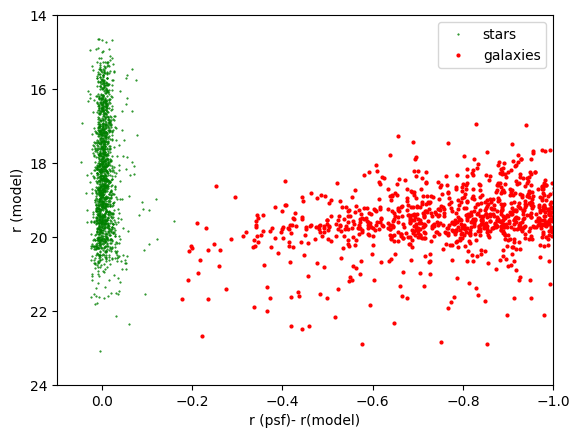

In [136]:
plt.plot(df2['modelMag_r'][df2['class']=='STAR']-df2['psfMag_r'][df2['class']=='STAR'],df2['modelMag_r'][df2['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.plot(df2['modelMag_r'][df2['class']=='GALAXY']-df2['psfMag_r'][df2['class']=='GALAXY'],df2['modelMag_r'][df2['class']=='GALAXY'],'o',ms=2,color='red',label='galaxies') 
plt.legend(loc="best")
plt.xlabel("r (psf)- r(model)")
plt.ylabel("r (model)")
plt.ylim(24,14)
plt.xlim(0.1,-1)
#plt.yscale("log")

Below I plot the images of the objects with classfications problems. 

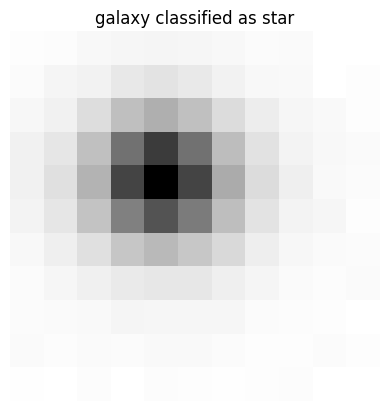

In [90]:
#all methods agree 
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[22,0,:,:].T,cmap=cm.gray, interpolation='nearest')

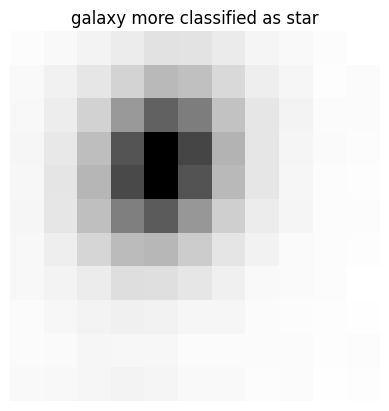

In [91]:
#convolutional different
plt.axis('off')
plt.title("galaxy more classified as star")
plt.imshow(-image_test[239,0,:,:].T,cmap=cm.gray, interpolation='nearest')

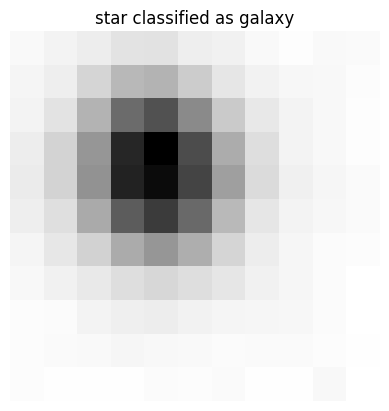

In [92]:
#xgboost disgarees 
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[915,0,:,:].T,cmap=cm.gray, interpolation='nearest')

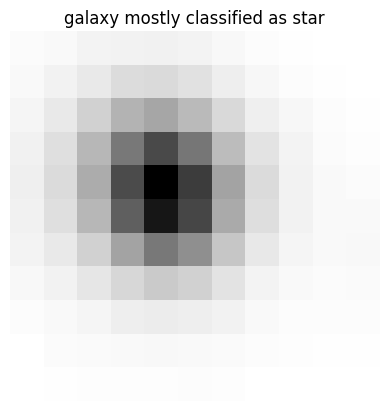

In [93]:
#perceptron is different from other methods
plt.axis('off')
plt.title("galaxy mostly classified as star")
plt.imshow(-image_test[1092,0,:,:].T,cmap=cm.gray, interpolation='nearest')

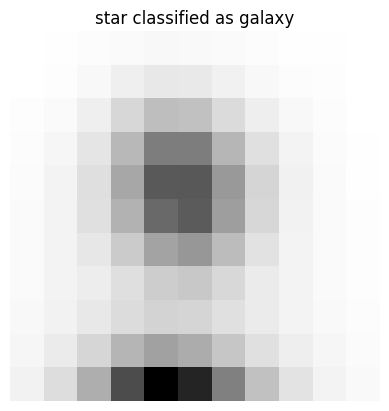

In [94]:
#all agree
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[1131,0,:,:].T,cmap=cm.gray, interpolation='nearest')

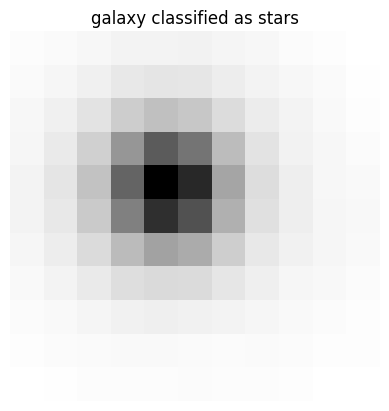

In [96]:
#all agree
plt.axis('off')
plt.title("galaxy classified as stars")
plt.imshow(-image_test[1289,0,:,:].T,cmap=cm.gray, interpolation='nearest')

The one above all look rather normal compact, there few if at all obvious galaxies to the eye.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in finding that. Thus looking on the images does not help. Algorithm are better. 

## Conclusions

It is rather to get a good classfication into star and galaxies, even simple methods like logistic achive very good results. None it is perfect, the reason for that is not clear, there are no clear problems with input classifications. Using more data likely helps to solve this problem.
For this prob;em it also would makes to look on others methods because the star class is very homogenous outlier detection methods are possible better. Also looking on shape based parameters like moments could be useful. 
That also simpler algorithms work well shows not unexpected that is not the best use case for neural networks. Still, they are also work. 